# Neural Networks with MicroGrad

This presentation is concerned with the general concept of *Neural Networks*, and does not touch on more complex topics such as *Generative AI*, however
since *Neural Networks* are building blocks of more architectures they are worth studying on their own. 

We'll start with high-level concepts and get an idea how *Neural Networks* work, at first treating the Calculus behind gradient descent as a *black box*, but going over all the moving parts that make *Neural Networks* work.  We'll dive into the Calculus in a future session if there is interest.

Notebook Demo starts at 1h:44min in Andrej's video: https://youtu.be/VMj-3S1tku0?si=_puXz5fzFOlUeLab&t=6242

### Other Useful Resources

* Andrej has taken other material from https://cs231n.github.io/convolutional-networks/ (Stanford CS231).  That seems interesting for future topics (like CNN)

* A summary of Machine learning terms: https://ml-cheatsheet.readthedocs.io/en/latest/index.html

Note: MicroGrad is modeled after **pytorch**, so it should be not too difficult to start out with MicroGrad for learning, then switch
to pytorch for performance.


## Key concepts

### Training Data

**training/evaluation data sets** In order to train any model you need to split your data into at least two sets: training, and evaluation. Each individual input (image for example) is called a $example$.

*Training data* consists of two sets of data: *inputs* ($X$) and *target* values ($y$). For each example $X^{(i)}$ you need a target that represents the value that we want the network to produce.

It is *critical* that you __do not use the same data for both training and evaluation__ because if you train your model on the exact data you evaluate it on you will *over-fit* your model.

### Regression vs. Classification

* **Regression** deals with continuous inputs/outputs.  If you can fit a polynomial function through the data to make a prediction, linear regression is a good fit. 

* **Classification** deals with classifying inputs into one or more categories.  It goes by *binary classification* when there are only two categores.  The example in the Notebook is a classification problem ($half\_moon$)

### Activation function

The **activation function** is: $a = g(z)$, where: $z = \overrightarrow{w\ } \cdot \overrightarrow{x\ } + b$  (we'll see more on this below under **Perceptron** section). 

A common activation function for binary classification is the *sigmoid function*, $g(z) = \frac{1}{1+e^{(-z)}}$ 

### Loss function
The Loss measures the total performance of the network. The goal of training the network is to adjust the parameters incrementally in order to **minimize the loss function**

**Mean Square Error (MSE)** 

This function is pretty easy to understand, so let's take a look at it:

$$J(w,b) = \frac{1}{2m} \sum\limits_{i=0}^{m-1} (y - t)^2$$

 $y$ is the prediction, $t$ is the target value (from the training set).  These are the terms Andrej uses in the code.

MSE is typically used for linear regression -- when  continuous output and a linear relationship between input and output.  

**Note** For the $half\_moon$ example in this notebook we are using **Hinge Loss** (also known as **svm "max-margin" loss**).  We will discuss that more when we get to that section. 


**Summary at the end of Andrej's presentation**, covering the key things we've learned. It may be good to review these at the end (it's just a few minutes)

https://youtu.be/VMj-3S1tku0?si=DiJXnjC-HKidXjbF&t=8043

### Gradient descent
Updating parameters a little bit at the time:
https://youtu.be/VMj-3S1tku0?si=s7xqxVQNrWau7rQa&t=7285

* think of the gradient as a vector pointing in the direction of increased loss, so in order to decrease 
the loss we decrease the parameter by the gradient (multiplied by the learning rate)
* between 2:01 (link above) and 2:09 - shows how we nudge the parameters to produces a smaller loss

#### Visualizing Gradient Descent
https://mathformachines.com/posts/visualizing-the-loss-landscape/

### What is a Neuron?

* Inputs X: in this example three inputs: $x_0$, $x_1$, $x_2$
* weights:  $w_0$, $w_1$, $w_2$
* bias $b$
* activation function: $f(\sum_i({w{_i}}\cdot{x_i}+ b))$

![Neural Network](images/neuron_model.jpeg)

### Assumptions about the math (from engine.py):

* Each Neuron contains its parameters (w's and b's), wrapped in an object (Value)
* in order for the network to learn, we need to be able to nudge parameters in a particular direction, and by a certain amount in order to minimize loss
* for each training step we need to do two passes:

    * forward pass in order to determine how well the network is doing given the **current** parameters; 
        * we build a network of connections between the parameters; 
        * we initialize $gradients$ -- values associated with each parameter

    * backward pass in order to update the $gradients$, so that next time we do a forward pass we will make a prediction that is just a little bit closer to the target value.

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Restart kernel when external files change

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

#### Set the seed, to get repeatable 
Question: what's the difference between the two seeds?

In [5]:
np.random.seed(1337)
random.seed(1337)

## Gather and visualize the Data

************
Input shapes: X:  (100, 2) y:  (100,)


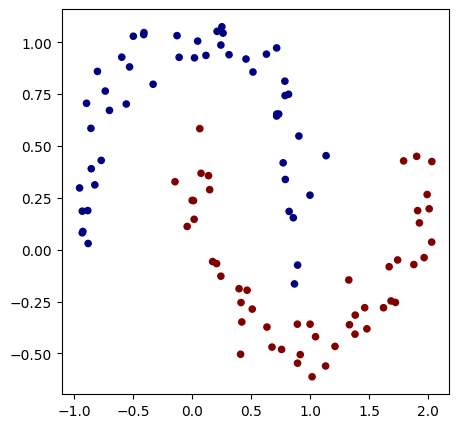

In [36]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

print("************")
print("Input shapes: X: ", X.shape, "y: ", y.shape)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

### The shape of the Network

Our MLP class is a densely-connected network, so every node (Perceptron) is connected to every other node in both the layer before and the layer after
So, that means that the **shape** of at each layer depends on on the number of nodes in the layer before and the layer after.

For example if we define a network with 3 inputs, and three layers with: 4, 5, and 6 nodes, and one output node, the shapes of the layers will be:
* layer 1: 3x4
* layer 2: 4x5
* layer 3: 5x6
* output layer: 6x1

### Create the Neural Network

In [7]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

Multi-Layer Perceptron Structure:
 Layer 1/3 - Shape of the layer is: 2 X 16 (nin X nout)
   Neuron 1: ReLUNeuron(2) -> w0 = 0.2355, w1 = 0.0665, b = 0.0000 
   Neuron 2: ReLUNeuron(2) -> w0 =-0.2683, w1 = 0.1716, b = 0.0000 
   Neuron 3: ReLUNeuron(2) -> w0 =-0.6686, w1 = 0.6487, b = 0.0000 
   Neuron 4: ReLUNeuron(2) -> w0 =-0.2326, w1 = 0.5792, b = 0.0000 
   Neuron 5: ReLUNeuron(2) -> w0 = 0.8435, w1 =-0.3847, b = 0.0000 
   Neuron 6: ReLUNeuron(2) -> w0 = 0.9845, w1 =-0.5901, b = 0.0000 
   Neuron 7: ReLUNeuron(2) -> w0 = 0.3126, w1 = 0.8246, b = 0.0000 
   Neuron 8: ReLUNeuron(2) -> w0 =-0.7814, w1 = 0.6409, b = 0.0000 
   Neuron 9: ReLUNeuron(2) -> w0 =-0.2025, w1 =-0.8693, b = 0.0000 
   Neuron 10: ReLUNeuron(2) -> w0 = 0.3984, w1 =-0.3038, b = 0.0000 
   Neuron 11: ReLUNeuron(2) -> w0 =-0.1928, w1 = 0.6032, b = 0.0000 
   Neuron 12: ReLUNeuron(2) -> w0 = 0.6001, w1 = 0.3275, b = 0.0000 
   Neuron 13: ReLUNeuron(2) -> w0 = 0.6650, w1 = 0.1889, b = 0.0000 
   Neuron 14: ReLUNeur

## Loss function

* **line 14:** is the **forward pass** through the network

* **line 16** svm "max-margin" loss
The hinge loss term ∑𝑖max(0,1−𝑦𝑖(𝐰⊺𝐱𝑖+𝑏))
 in soft margin SVM penalizes misclassifications. In hard margin SVM there are, by definition, no misclassifications. More here: https://en.wikipedia.org/wiki/Hinge_loss

* **line 19:** **Regularization** is a technique used in machine learning and deep learning to prevent overfitting and improve the generalization performance of a model. It involves adding a penalty term to the loss function during training.  More on this here: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/#:~:text=Regularization%20is%20a%20technique%20used,the%20loss%20function%20during%20training.



In [41]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    print("Xb:", Xb[:1], "inputs:", inputs[:1])
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print("total_loss: ", total_loss, " activation: ", acc)

Xb: [[0.24359556 0.98688097]] inputs: [[Value(data=0.2435955591026185, grad=0), Value(data=0.9868809652803922, grad=0)]]
total_loss:  Value(data=0.04312049649639047, grad=0)  activation:  1.0


## Optimization

* **learning rate decay:** learning rate decreases over time (1.0 -> 0.18).  This can improve performance by taking larger steps.
initially, and over time smaller ones.  

In [26]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100    
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    #if k % 1 == 0:
    print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")


[[Value(data=1.1221146075409685, grad=0), Value(data=0.08147717341718697, grad=0)], [Value(data=-0.8188294130836691, grad=0), Value(data=0.058790063907949996, grad=0)]]
step 0 loss 0.010951573506532237, accuracy 100.0%


(-1.548639298268643, 1.951360701731357)

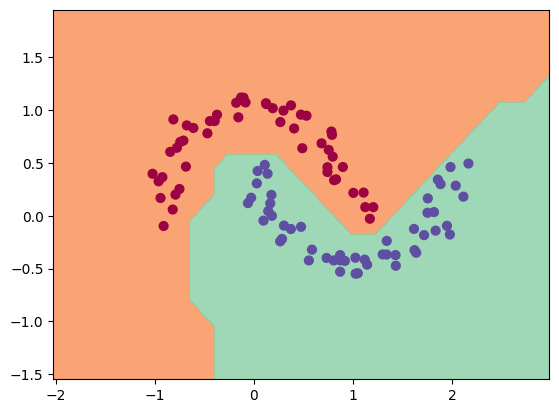

In [14]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
